In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split

Mask = glob('train/Mask/*.jpg')
No_Mask = glob('train/No_Mask/*.jpg')

Mask_train, Mask_test = train_test_split(Mask, test_size=0.30)
No_Mask_train, No_Mask_test = train_test_split(No_Mask, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Mask
files = ' '.join(Mask_test)
!mv -t test/Mask $files

!mkdir test/No_Mask
files = ' '.join(No_Mask_test)
!mv -t test/No_Mask $files

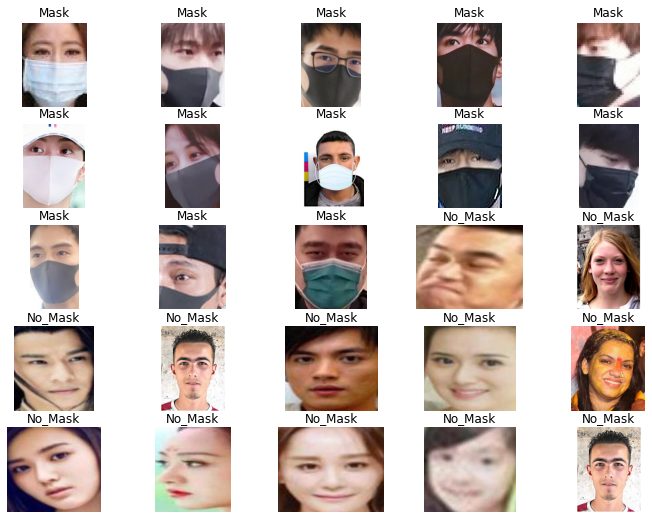

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Mask = np.random.choice(Mask_train, 13)
No_Mask = np.random.choice(No_Mask_train, 12)
data = np.concatenate((Mask, No_Mask))
labels = 13 * ['Mask'] + 12 *['No_Mask']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 3414 images belonging to 2 classes.
Found 1464 images belonging to 2 classes.


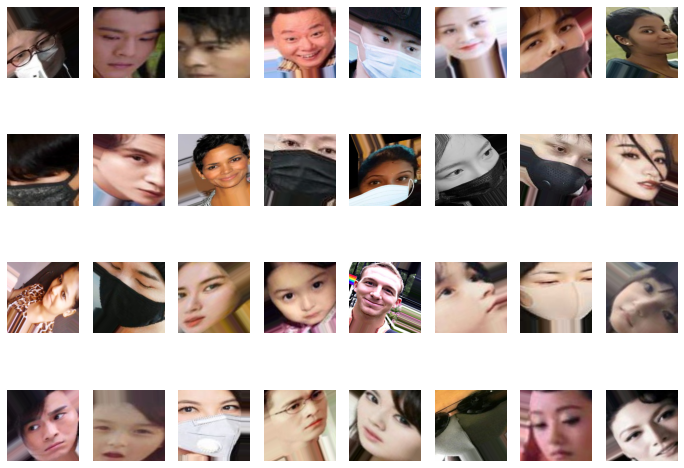

In [6]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [7]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'MaskD.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
320/320 [==============================] - 183s 572ms/step - loss: 0.1077 - accuracy: 0.9593 - val_loss: 0.0506 - val_accuracy: 0.9853
Epoch 2/5
320/320 [==============================] - 187s 585ms/step - loss: 0.0480 - accuracy: 0.9837 - val_loss: 0.0462 - val_accuracy: 0.9824
Epoch 3/5
320/320 [==============================] - 190s 595ms/step - loss: 0.0405 - accuracy: 0.9862 - val_loss: 0.0361 - val_accuracy: 0.9882
Epoch 4/5
320/320 [==============================] - 196s 612ms/step - loss: 0.0442 - accuracy: 0.9853 - val_loss: 0.0461 - val_accuracy: 0.9863
Epoch 5/5
320/320 [==============================] - 196s 613ms/step - loss: 0.0410 - accuracy: 0.9863 - val_loss: 0.0371 - val_accuracy: 0.9872
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MaskD.model/assets


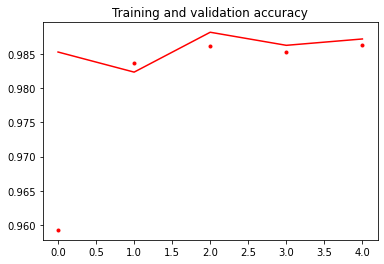

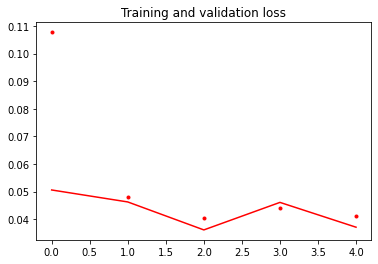

In [10]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Mask", "No_Mask")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [3]:
model = load_model(MODEL_FILE)

NameError: name 'MODEL_FILE' is not defined

In [ ]:
img = image.load_img('download (2).jpeg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

In [4]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [ ]:
#From Webcam using OpenCvDNN
import cv2  
import os
import numpy as np
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
prototxt_path = os.path.join('deploy.prototxt')
caffemodel_path = os.path.join('weights.caffemodel')
modelCV = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
cap = cv2.VideoCapture("Video Footage People Showing How To Wear Face Mask.mp4")
#cap = cv2.VideoCapture(0)
model = load_model('MaskD.model')
while 1:  

    ret, img = cap.read()  
    #img = cv2.flip(img, 1)
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    modelCV.setInput(blob)
    detections = modelCV.forward()
 
    for i in range(0, detections.shape[2]): 
        startX, startY, endX, endY=0,0,0,0 
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        confidence = detections[0, 0, i, 2]
        if (confidence > 0.5):
            cv2.rectangle(img, (startX, startY), (endX, endY), (255, 255, 255), 2)
            roi_color = img[startY:endY, startX:endX]
            preds = predict(model, roi_color)
            #cv2.putText(img, preds, (startX+20,50), cv2.FONT_HERSHEY_SIMPLEX,  1, (255, 0, 0), 2, cv2.LINE_AA)
            #print(preds[1])
            if(preds[0]>preds[1]):
                cv2.putText(img, 'Mask', (startX,endY+30), cv2.FONT_HERSHEY_SIMPLEX,  1, (255, 0, 0), 1, cv2.LINE_AA)
            
            elif(preds[1]>preds[0]):
                cv2.putText(img, 'No Mask', (startX,endY+30), cv2.FONT_HERSHEY_SIMPLEX,  1, (255, 0, 0), 1, cv2.LINE_AA)
        else:
            continue
            
    
    cv2.imshow('CVCNN',img) 
  
    # Wait for Esc key to stop 
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break
  
# Close the window 
cap.release() 
  
# De-allocate any associated memory usage 
cv2.destroyAllWindows()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
